Dieses Skript soll Karten von Inkar und CBS zusammenfügen

In [1]:
import pandas as pd
import geopandas as gpd
import cbsodata
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_netherlands = pd.DataFrame(cbsodata.get_meta('03747', 'TypedDataSet'))

In [4]:


#data_nl = data_netherlands[['ID', 'Persoonskenmerken', 'RegioS','Perioden','LevendGeborenKinderenRelatief_2']]
data_nl = data_netherlands[['ID', 'RegioS','Perioden','MannenEnVrouwen_4']]

data_nl = data_nl[data_nl['Perioden'] == '2020JJ00']
data_nl['Perioden'] = data_nl['Perioden'].str.extract(r'(\d{4})')

#data_nl = data_nl[data_nl['Persoonskenmerken'] == 'T009002']

data_nl.replace(0, np.nan, inplace=True)
data_nl = data_nl.dropna()

data_nl


,ID,RegioS,Perioden,MannenEnVrouwen_4
32,32,NL01,2020,9.7
68,68,LD01,2020,10.2
104,104,LD02,2020,9.6
140,140,LD03,2020,9.1
176,176,LD04,2020,10.9
...,...,...,...,...
31856,31856,GM0879,2020,11.2
31892,31892,GM0301,2020,9.8
31928,31928,GM1896,2020,8.9
32036,32036,GM0642,2020,12.5


In [4]:
data_de = pd.read_csv("out/csvs/indicator_Gestorbene.csv")

data_de = data_de[data_de['Zeitbezug'] == 2020]

#data_de['Wert'] = data_de['Wert'] / 1000

#data_de.replace(0, np.nan, inplace=True)
data_de = data_de.dropna()

data_de

,Kennziffer,Wert,Zeitbezug
25,111,11.85,2020
51,1,12.09,2020
77,2,9.88,2020
103,3,12.12,2020
129,4,11.98,2020
...,...,...,...
125135,16073000,17.18,2020
125161,16074000,11.94,2020
125187,16075000,15.18,2020
125213,16076000,17.50,2020


Niederländische GEO-Saten abfragen und speichern

In [5]:

municipal_boundaries_nl = gpd.read_file(filename='GeoJSON:https://service.pdok.nl/cbs/gebiedsindelingen/2021/wfs/v1_0?request=GetFeature&service=WFS&version=1.1.0&outputFormat=json&typeName=gebiedsindelingen:gemeente_gegeneraliseerd', engine="pyogrio")

municipal_boundaries_nl = municipal_boundaries_nl[['statcode', 'statnaam', 'geometry']]

municipal_boundaries_nl = pd.merge(municipal_boundaries_nl, data_nl,
                               left_on = "statcode", 
                               right_on = "RegioS")

municipal_boundaries_nl = municipal_boundaries_nl[['statcode', 'statnaam', 'geometry', 'RegioS', 'MannenEnVrouwen_4', 'Perioden' ]]

municipal_boundaries_nl.columns = ['Code', 'Name', 'geometry', 'Kennziffer', 'Wert', 'Zeitbezug']

municipal_boundaries_nl


,Code,Name,geometry,Kennziffer,Wert,Zeitbezug
0,GM0014,Groningen,"MULTIPOLYGON (((245194.691 592594.007, 245344....",GM0014,7.7,2020
1,GM0034,Almere,"MULTIPOLYGON (((146891.056 493291.709, 147422....",GM0034,5.1,2020
2,GM0037,Stadskanaal,"MULTIPOLYGON (((263763.866 566430.392, 263988....",GM0037,13.9,2020
3,GM0047,Veendam,"MULTIPOLYGON (((256231.909 572319.213, 258595....",GM0047,11.3,2020
4,GM0050,Zeewolde,"MULTIPOLYGON (((170596.293 486786.456, 170560....",GM0050,5.1,2020
...,...,...,...,...,...,...
346,GM1963,Hoeksche Waard,"MULTIPOLYGON (((97460.999 412337.999, 96725.94...",GM1963,9.8,2020
347,GM1966,Het Hogeland,"MULTIPOLYGON (((215071.742 595253.084, 215169....",GM1966,10.4,2020
348,GM1969,Westerkwartier,"MULTIPOLYGON (((217623.770 592502.490, 217917....",GM1969,9.3,2020
349,GM1970,Noardeast-Fryslân,"MULTIPOLYGON (((207686.537 595425.623, 207640....",GM1970,10.7,2020


Deutsche GEO-Daten abfragen und abspeichern

In [6]:
municipal_boundaries_de = gpd.read_file(filename='../data/DE_VG250.gpkg', layer="vg250_krs",engine="pyogrio")

municipal_boundaries_de['AGS_int'] = municipal_boundaries_de.AGS_0.astype(int)

municipal_boundaries_de = municipal_boundaries_de[municipal_boundaries_de['GF'] == 4]

municipal_boundaries_de = municipal_boundaries_de[['AGS_int', 'GEN', 'geometry']]

municipal_boundaries_de = pd.merge(municipal_boundaries_de, data_de,
                             left_on = "AGS_int", 
                              right_on = "Kennziffer")

municipal_boundaries_de.columns = ['Code', 'Name', 'geometry', 'Kennziffer', 'Wert', 'Zeitbezug']

municipal_boundaries_de



,Code,Name,geometry,Kennziffer,Wert,Zeitbezug
0,1001000,Flensburg,"MULTIPOLYGON (((526513.753 6075133.412, 526547...",1001000,11.84,2020
1,1002000,Kiel,"MULTIPOLYGON (((575841.569 6032148.032, 575869...",1002000,10.44,2020
2,1003000,Lübeck,"MULTIPOLYGON (((623056.151 5983746.445, 623191...",1003000,13.02,2020
3,1004000,Neumünster,"MULTIPOLYGON (((565015.652 6000637.513, 565128...",1004000,13.68,2020
4,1051000,Dithmarschen,"MULTIPOLYGON (((479877.791 5990290.587, 479947...",1051000,13.25,2020
...,...,...,...,...,...,...
395,16073000,Saalfeld-Rudolstadt,"MULTIPOLYGON (((659352.786 5633725.523, 659501...",16073000,17.18,2020
396,16074000,Saale-Holzland-Kreis,"MULTIPOLYGON (((688961.348 5662575.516, 688976...",16074000,11.94,2020
397,16075000,Saale-Orla-Kreis,"MULTIPOLYGON (((699461.667 5630277.321, 699499...",16075000,15.18,2020
398,16076000,Greiz,"MULTIPOLYGON (((724109.327 5650625.772, 724321...",16076000,17.50,2020


Karte der Niederlande erstellen

Text(0.5, 1.0, 'fisherjenks, 2020')

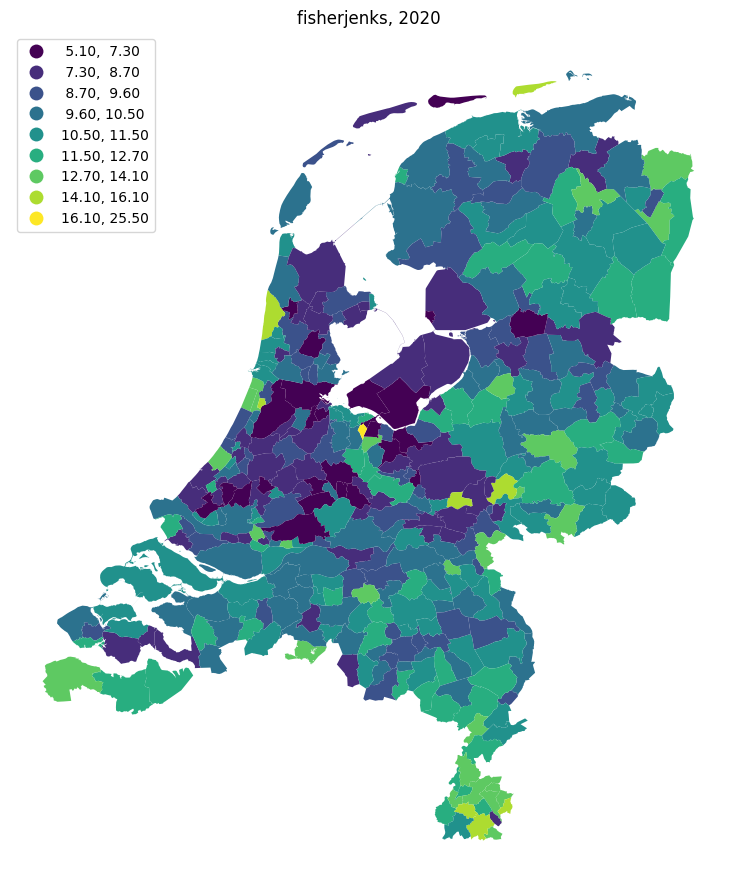

In [7]:
scheme = "fisherjenks"
year = municipal_boundaries_nl['Zeitbezug'][1]
p = municipal_boundaries_nl.plot(column='Wert',
                             scheme=scheme,
                             k=9,
                             legend=True,
                             legend_kwds={'loc': 'upper left'},
                             figsize = (11,11))
p.axis('off')
p.set_title(scheme + ', ' + year)

Karte von Deutschland erstellen

Text(0.5, 1.0, 'quantiles, 2020')

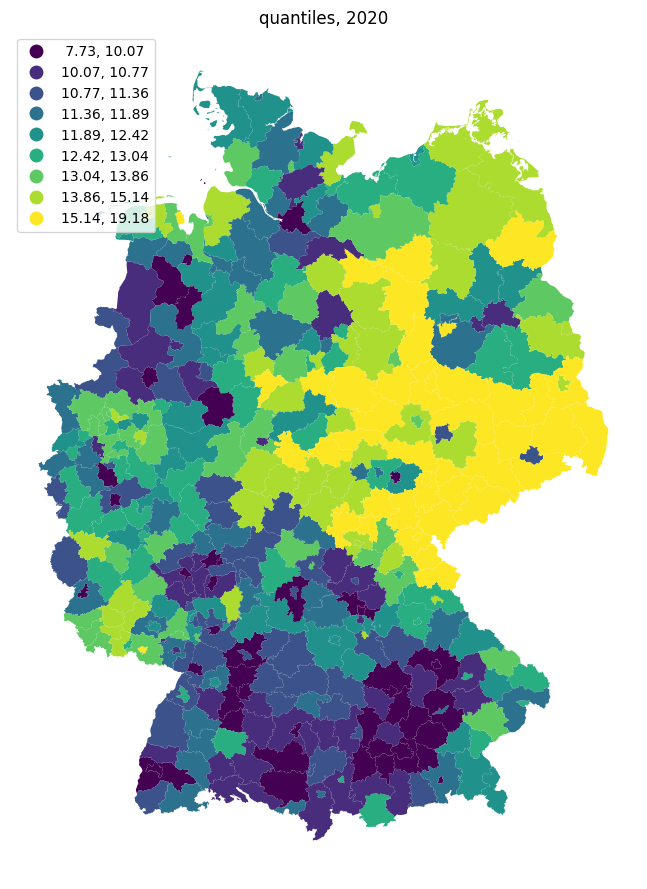

In [8]:
scheme = "quantiles"
year = municipal_boundaries_de['Zeitbezug'][1]
year = year.astype('str')
p = municipal_boundaries_de.plot(column='Wert',
                             scheme=scheme,
                             k=9,
                             legend=True,
                             legend_kwds={'loc': 'upper left'},
                             figsize = (11,11))
p.axis('off')
p.set_title(scheme + ', ' + year)

Beide Karten miteinander verbinden

In [9]:
# gleiche Gebietsstände festlegen
de = municipal_boundaries_de.to_crs('epsg:3035')
nl = municipal_boundaries_nl.to_crs('epsg:3035')

#Daten verbinden
data_mixed = pd.concat([nl, de], ignore_index=True)

data_mixed


,Code,Name,geometry,Kennziffer,Wert,Zeitbezug
0,GM0014,Groningen,"MULTIPOLYGON (((4103810.729 3360893.031, 41039...",GM0014,7.70,2020
1,GM0034,Almere,"MULTIPOLYGON (((3999375.839 3268013.648, 39998...",GM0034,5.10,2020
2,GM0037,Stadskanaal,"MULTIPOLYGON (((4120663.331 3333600.459, 41208...",GM0037,13.90,2020
3,GM0047,Veendam,"MULTIPOLYGON (((4113524.608 3339956.737, 41158...",GM0047,11.30,2020
4,GM0050,Zeewolde,"MULTIPOLYGON (((4022614.611 3260017.421, 40225...",GM0050,5.10,2020
...,...,...,...,...,...,...
746,16073000,Saalfeld-Rudolstadt,"MULTIPOLYGON (((4409973.500 3080963.490, 44101...",16073000,17.18,2020
747,16074000,Saale-Holzland-Kreis,"MULTIPOLYGON (((4439969.466 3109415.347, 44399...",16074000,11.94,2020
748,16075000,Saale-Orla-Kreis,"MULTIPOLYGON (((4450032.187 3076981.042, 44500...",16075000,15.18,2020
749,16076000,Greiz,"MULTIPOLYGON (((4474946.993 3096997.500, 44751...",16076000,17.50,2020


Text(0.5, 1.0, 'FisherJenks, 2020, Gestorbene')

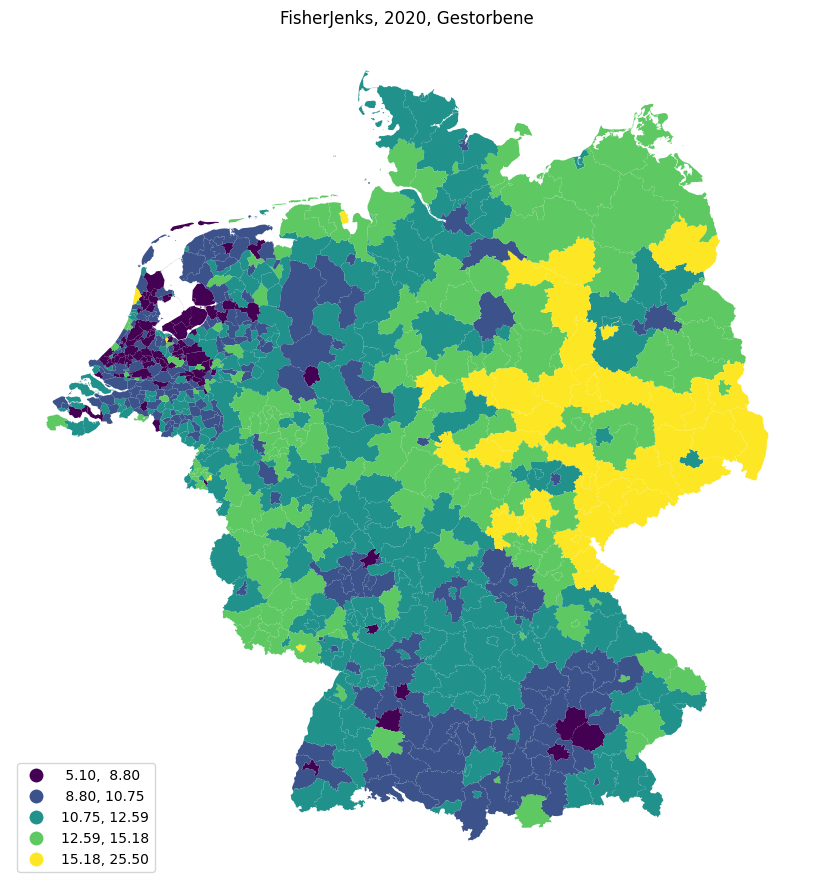

In [10]:
scheme = "FisherJenks"
year = data_mixed['Zeitbezug'][1]
p = data_mixed.plot(column='Wert',
                             scheme=scheme,
                             k=5,
                             legend=True,
                             legend_kwds={'loc': 'lower left'},
                             figsize = (11,11))
p.axis('off')
p.set_title(scheme + ', ' + year+ ', Gestorbene')

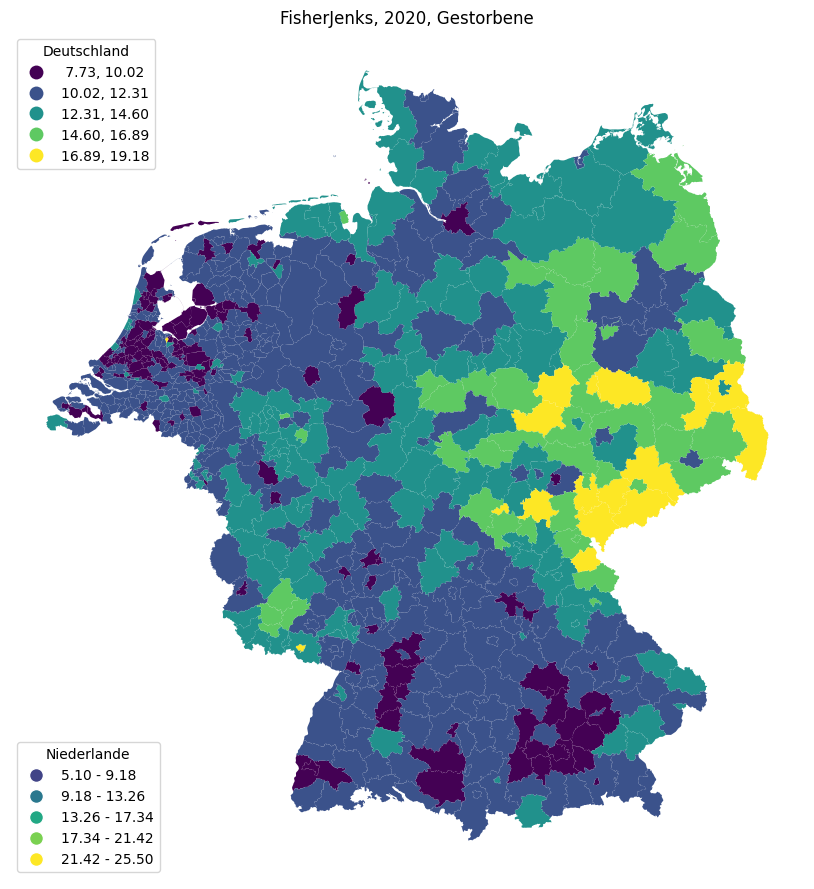

In [18]:
# Code, umzwei legenden in der Abbildung zu haben
from matplotlib.lines import Line2D
from mapclassify import EqualInterval, Quantiles, FisherJenks

fig, ax = plt.subplots(figsize=(11, 11))

# Plot der Deutschen Karte
de_plot = de.plot(ax=ax, column='Wert', scheme="EqualInterval", k=5, legend=True, legend_kwds={'loc': 'upper left'})
legend1 = ax.get_legend()
legend1.set_title('Deutschland')

#Plot der NL Karte
nl_plot = nl.plot(ax=ax, column='Wert', scheme="EqualInterval", k=5, legend=False)
scheme = EqualInterval(nl['Wert'], k=5)
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=nl['Wert'].min(), vmax=nl['Wert'].max())

handles2 = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(bin)), markersize=10,
           label=f'{scheme.bins[i-1]:.2f} - {scheme.bins[i]:.2f}' if i > 0 else f'{nl["Wert"].min():.2f} - {scheme.bins[i]:.2f}')
    for i, bin in enumerate(scheme.bins)
]

ax.add_artist(legend1)  
legend2 = ax.legend(handles=handles2, loc='lower left', title='Niederlande')


plt.axis('off')
#plt.suptitle("FisherJenks" + ', ' + year + ', Gestorbene')
de_plot.set_title("FisherJenks" + ', ' + year+ ', Gestorbene')
plt.show()


Graphen zu den Karten erstellen

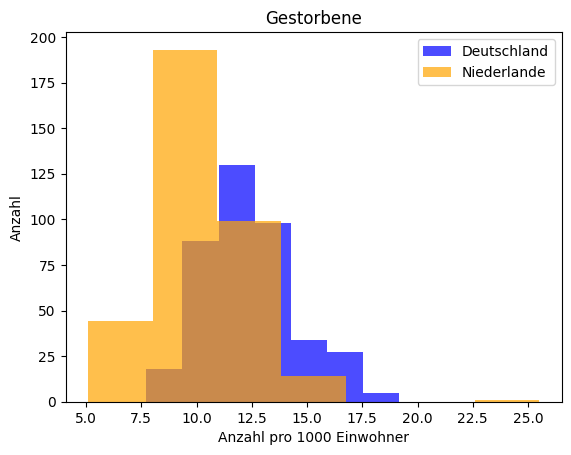

In [57]:
plt.hist(de['Wert'], bins=7, color='blue', alpha=0.7, label='Deutschland', histtype='bar')
plt.hist(nl['Wert'], bins=7, color='orange', alpha=0.7, label='Niederlande', histtype='bar')

plt.xlabel('Anzahl pro 1000 Einwohner')
plt.ylabel('Anzahl')
plt.title('Gestorbene')
plt.legend()
plt.show()


<Axes: >

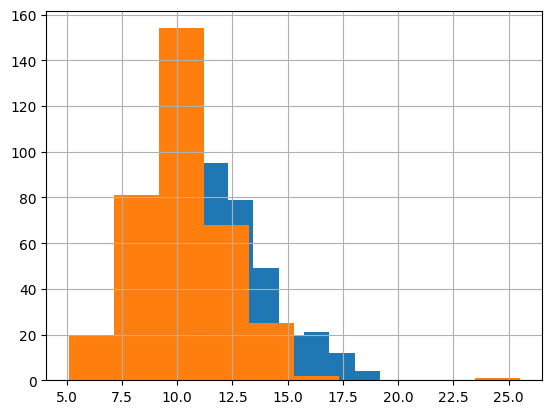

In [44]:
de['Wert'].hist(label='Deutschland')
nl['Wert'].hist(label='Niederlande')
